# YOLOv8 text region detection

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import os
import cv2

In [2]:
import torch
print(torch.cuda.is_available())

True


In [17]:
import os
import json
import cv2
import random

## Convert ICDAR Annotations to YOLO

In [ ]:
DATASET_PATH = "../../datasets/icdar2013"
SAVE_PATH = "../../datasets/yolo_format/icdar2013"
IMAGE_PATH = os.path.join(DATASET_PATH, "Challenge2_Training_Task12_Images")
ANNOTATION_FILES = ["train_gt.json", "test_gt.json"]

In [ ]:
os.makedirs(os.path.join(SAVE_PATH, "images"), exist_ok=True)
os.makedirs(os.path.join(SAVE_PATH, "labels"), exist_ok=True)

In [ ]:
def convert_to_yolo_format(bbox, img_w, img_h):
    x_min = min(pt[0] for pt in bbox)
    x_max = max(pt[0] for pt in bbox)
    y_min = min(pt[1] for pt in bbox)
    y_max = max(pt[1] for pt in bbox)

    x_center = (x_min + x_max) / 2 / img_w
    y_center = (y_min + y_max) / 2 / img_h
    width = (x_max - x_min) / img_w
    height = (y_max - y_min) / img_h

    return f"0 {x_center} {y_center} {width} {height}"

In [ ]:
for ann_file in ANNOTATION_FILES:
    ann_path = os.path.join(DATASET_PATH, ann_file)
    
    with open(ann_path, "r") as f:
        data = json.load(f)

    for img_name, ann_data in data["annots"].items():
        img_path = os.path.join(IMAGE_PATH, img_name)

        if not os.path.exists(img_path):
            print(f"Skipping {img_path} (not found)")
            continue

        img = cv2.imread(img_path)
        h, w, _ = img.shape

        yolo_annotations = [
            convert_to_yolo_format(bbox, w, h) for bbox in ann_data["bbox"]
        ]

        # Save YOLO annotation file
        label_file = os.path.join(SAVE_PATH, "labels", img_name.replace(".jpg", ".txt"))
        with open(label_file, "w") as f:
            f.write("\n".join(yolo_annotations))

        # Copy images to YOLO dataset folder
        img_save_path = os.path.join(SAVE_PATH, "images", img_name)
        cv2.imwrite(img_save_path, img)

print("✅ ICDAR 2013 dataset converted to YOLO format successfully!")

Skipping ../../datasets/icdar2013\Challenge2_Training_Task12_Images\img_159.jpg (not found)
Skipping ../../datasets/icdar2013\Challenge2_Training_Task12_Images\img_5.jpg (not found)
Skipping ../../datasets/icdar2013\Challenge2_Training_Task12_Images\img_232.jpg (not found)
Skipping ../../datasets/icdar2013\Challenge2_Training_Task12_Images\img_144.jpg (not found)
Skipping ../../datasets/icdar2013\Challenge2_Training_Task12_Images\img_201.jpg (not found)
Skipping ../../datasets/icdar2013\Challenge2_Training_Task12_Images\img_223.jpg (not found)
Skipping ../../datasets/icdar2013\Challenge2_Training_Task12_Images\img_228.jpg (not found)
Skipping ../../datasets/icdar2013\Challenge2_Training_Task12_Images\img_86.jpg (not found)
Skipping ../../datasets/icdar2013\Challenge2_Training_Task12_Images\img_21.jpg (not found)
Skipping ../../datasets/icdar2013\Challenge2_Training_Task12_Images\img_152.jpg (not found)
Skipping ../../datasets/icdar2013\Challenge2_Training_Task12_Images\img_42.jpg (not 

## Convert MSRA-TD500 Annotations to YOLO

In [14]:
DATASET_PATH = "../../datasets/msra_td500"
SAVE_PATH = "../../datasets/yolo_format/msra_td500"
IMAGE_FOLDERS = ["test", "train"]
os.makedirs(os.path.join(SAVE_PATH, "images"), exist_ok=True)
os.makedirs(os.path.join(SAVE_PATH, "labels"), exist_ok=True)

In [15]:
def convert_to_yolo_format(x, y, w, h, img_w, img_h):
    """ Convert MSRA-TD500 annotation to YOLO format """
    x_center = x / img_w
    y_center = y / img_h
    width = w / img_w
    height = h / img_h
    return f"0 {x_center} {y_center} {width} {height}"

In [16]:
for folder in IMAGE_FOLDERS:
    image_folder = os.path.join(DATASET_PATH, folder)
    
    for file in os.listdir(image_folder):
        if file.endswith(".JPG"):
            img_path = os.path.join(image_folder, file)
            gt_path = os.path.join(image_folder, file.replace(".JPG", ".gt"))

            # Skip if annotation file is missing
            if not os.path.exists(gt_path):
                continue

            # Read image size
            img = cv2.imread(img_path)
            h, w, _ = img.shape

            yolo_annotations = []
            with open(gt_path, "r") as f:
                for line in f.readlines():
                    vals = line.strip().split()
                    _, _, x, y, box_w, box_h, _ = map(float, vals)

                    # Convert to YOLO format
                    yolo_annotations.append(convert_to_yolo_format(x, y, box_w, box_h, w, h))

            # Save YOLO annotation file
            label_file = os.path.join(SAVE_PATH, "labels", file.replace(".JPG", ".txt"))
            with open(label_file, "w") as f:
                f.write("\n".join(yolo_annotations))

            # Copy images to YOLO dataset folder
            img_save_path = os.path.join(SAVE_PATH, "images", file)
            cv2.imwrite(img_save_path, img)

print("✅ MSRA-TD500 dataset converted to YOLO format successfully!")

✅ MSRA-TD500 dataset converted to YOLO format successfully!


## Visualization of the Annotations

In [18]:
BASE_PATH = "../../datasets/yolo_format"
DATASETS = ["icdar2013", "msra_td500"]

In [28]:
def load_random_images(num_images=9):
    """ Load random images from both datasets """
    image_paths = []

    for dataset in DATASETS:
        image_folder = os.path.join(BASE_PATH, dataset, "images")
        label_folder = os.path.join(BASE_PATH, dataset, "labels")

        # Get list of image files
        image_files = [f for f in os.listdir(image_folder) if f.endswith(".jpg")]
        random.shuffle(image_files)

        # Select images randomly
        for img_file in image_files:
            img_path = os.path.join(image_folder, img_file)
            label_path = os.path.join(label_folder, img_file.replace(".jpg", ".txt"))

            # Only include images that have a corresponding annotation file
            if os.path.exists(label_path):
                image_paths.append((img_path, label_path))
            if len(image_paths) >= num_images:
                break

    return image_paths

In [29]:
def plot_images_with_bboxes(num_images=9):
    """ Plot a set of images with detected text areas """
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.flatten()

    # Load images and annotations
    image_paths = load_random_images(num_images)

    for i, (img_path, label_path) in enumerate(image_paths):
        # Load image
        img = cv2.imread(img_path)
        if img is None:
            axes[i].axis("off")
            continue  # Skip if image cannot be loaded
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w, _ = img.shape

        # Read YOLO annotations
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                for line in f.readlines():
                    vals = line.strip().split()
                    _, x_center, y_center, bbox_w, bbox_h = map(float, vals)

                    # Convert from YOLO format to pixel coordinates
                    x1 = int((x_center - bbox_w / 2) * w)
                    y1 = int((y_center - bbox_h / 2) * h)
                    x2 = int((x_center + bbox_w / 2) * w)
                    y2 = int((y_center + bbox_h / 2) * h)

                    # Draw bounding box
                    cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)

        # Plot image
        axes[i].imshow(img)
        axes[i].axis("off")

    # Hide any unused axes
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

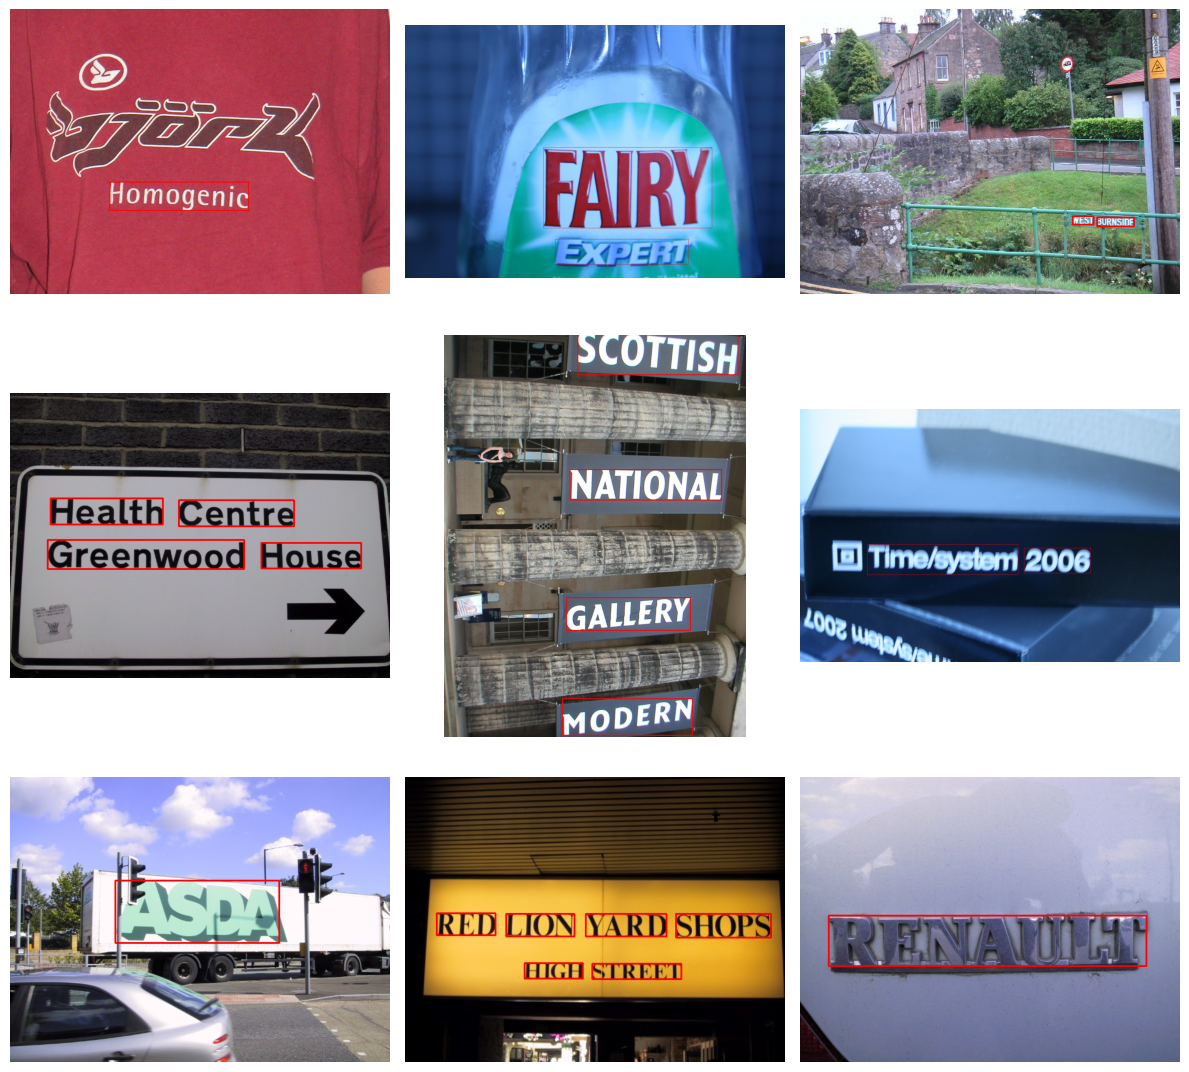

In [30]:
plot_images_with_bboxes()

Good